<h1>Customer Segmentation Project</h1>

<h3>Project Goal:</h3> To identify meaningful segments of customers from an email marketing campaign for wine discounts.  
<h3>Description of the Problem</h3>
There may be certain segments of customers that are similar to each other in terms of their wine preferences. One basic example of wine customer segments would be two segments, one segment of customers who drink only red wine, and another segment that drinks only white wine. In reality, the real segments are likely to be more complicated. 

If customer segments do exist, there are a few reasons this information could be useful:
<ul>
  <li>Focused marketing - If the segments reflect preferences for certain wines, future wine offers can be personalized to fit those preferences</li>
  <li>Steer growth - If some customer segments tend to make purchases with higher margins, efforts to acquire new customers can focus on finding and acquiring more customers in these segments</li>
</ul>

For this dataset, I don't know ahead of time whether any customer segments exist or what they might look like. This type of problem is referred to as "unsupervised learning", because there is no specific "target" variable in the data I'm seeking to predict. Fortunately, there are a class of algorithms designed to solve unsupervised learning problems like this one. 

<h2>Data Importing and Exploring</h2>

First I import a few libraries and tools to use in the rest of the analysis. 

In [1]:
import pandas as pd
import numpy as np

# plotting tools
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# scikit learn libraries for the cluster analysis and scoring
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

The dataset has two tables of data stored as excel file sheets, "offers" and "orders", which I import as pandas dataframes.  

In [2]:
offers = pd.read_excel("../data/wine/wine.xlsx", sheet_name=0)
orders = pd.read_excel("../data/wine/wine.xlsx", sheet_name=1)

I start by renaming some columns and printing a few records to understand the data structure.

In [3]:
offers.columns = ["offer_id", "month", "varietal", "min_qty", "discount", "origin", "past_peak"]
print offers.shape
offers.head()

(32, 7)


,offer_id,month,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


The "offers" data contains information about 32 offers. Each offer has an ID number, the month of the campaign, the wine varietal, the minimum quantity for the purchase, the discount amount, the country of origin, and whether the wine is past its peak or not. 

In [4]:
orders.columns = ["name", "offer_id"]
print orders.shape
orders.head()

(324, 2)


,name,offer_id
0,Smith,2
1,Smith,24
2,Johnson,17
3,Johnson,24
4,Johnson,26


The second table contains data on 324 customer orders, with each row containing the customer name and offer ID for each order. 

Before I jump into customer segmentation analysis, I run through some basic data exploration and visualization to gain a better high-level understanding of the data.

First I examine the orders data. Here I group the data by customer, count the number of orders per customer, and return some basic summary statistics. 

In [5]:
print orders.groupby('name')['offer_id'].count().describe()

count    100.000000
mean       3.240000
std        1.608814
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        9.000000
Name: offer_id, dtype: float64


The dataset has 100 customers, with an average of 3.24 orders per customer, ranging from 1-9 orders per customer.  
Because the customers data by itself only includes the customer name and the ID of the offer purchased, there isn't much else to see here

Next I examine the offers data. My first goal is to see how the volume of the offers is spread across the factors that define each wine offer, such as the month of the offer, the varietal, and the country of origin. 

### Visualizing volume for categorical factors

To visualize the volume of offers for each factor, I create a function that uses any given factor I choose (e.g., varietal) and plots the number of offers for each level of that factor. 

In [6]:
def plot_offers(factor):
    # group by factor levels and count offers within each level
    factor_totals = offers.groupby(factor, sort=False)['offer_id'].count()
    
    # get arrays to plot for offer counts and factor values
    totals = factor_totals.values
    factor_vals = factor_totals.index
    
    # create plot
    plt.figure(figsize=(14, 4))
    plt.plot(factor_vals, totals)
    plt.ylim(ymin=0, ymax=max(totals) + 1)
    ytitle = "Offers per %s" % (factor)
    ptitle = "Total number of offers for each %s" % (factor)
    plt.ylabel(ytitle)
    plt.title(ptitle)

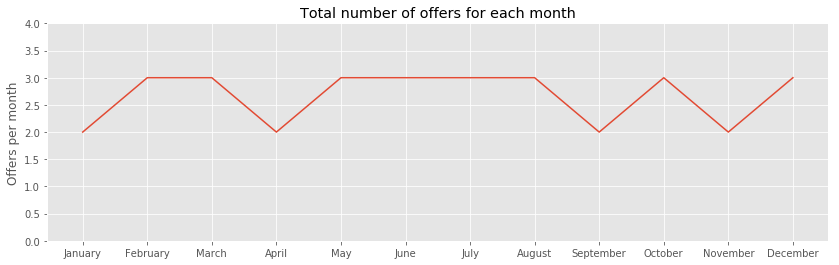

In [7]:
plot_offers('month')

The offers are sent with consistent frequency, at about 2-3 offers per month. 

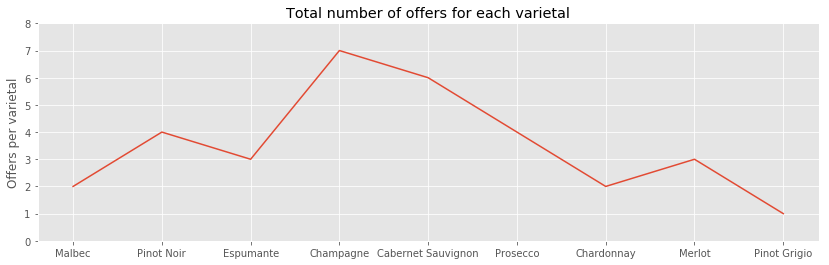

In [8]:
plot_offers('varietal')

Champagne and Cabernet Sauvignon are the most common wines, followed by Prosecco and Pinot Noir.  

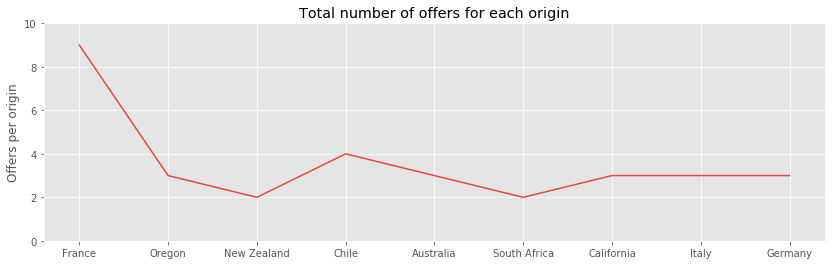

In [9]:
plot_offers('origin')

French wines comprise the most offers sent with 9, while no other origins have more than 4. 

### Visualizing continuous variables for each varietal

The offers data also includes two continuous variables, discount amount and minimum quantity.  
I'm intersested in comparing the varietals on these two variables, so I define a function to plot the mean for each varietal. 

In [10]:
# dict to plot better explanatory text for each continuous variable
metric_dict = {"min_qty": "minimum quantity", "discount": "discount amount"}

def plot_varietal_stat(metric):
    # group offers by variable and get mean of the metric
    varietal_stat = offers.groupby('varietal')[metric].mean()
    
    # get arrays to plot for varietal means and varietal names
    means = varietal_stat.values
    varietals = varietal_stat.index
    
    # create plote
    plt.figure(figsize=(14, 4))
    plt.plot(varietals, means)
    plt.ylim(ymin=0)
    ytitle = "Average %s" % (metric_dict[metric])
    plt.ylabel(ytitle)
    plt.title(ytitle + " for each varietal")

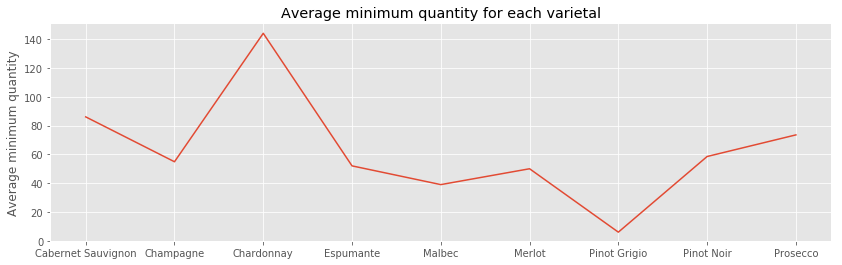

In [11]:
plot_varietal_stat('min_qty')

Most varietals have average minimum quantity close to 50. Chardonnay looks like an outlier, with offers close to 140 in minimum quantity. 

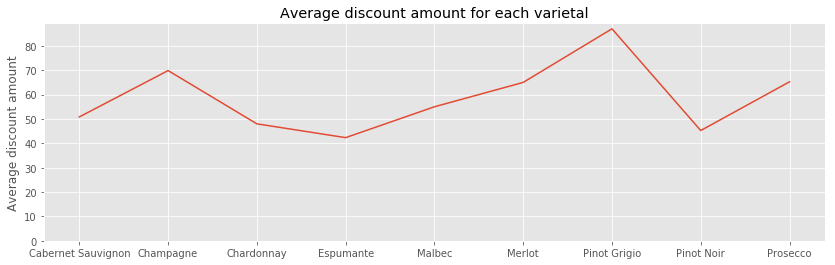

In [12]:
plot_varietal_stat('discount')

The average discount amount is between 40-75 for almost every varietal. Pinot Grigio, Champagne, Merlot, and Prosecco have the highest average discounts, while Espumante and Chardonnay had the lowest average discount.

<h3>Data Exploration: Insights</h3>  
With just a few lines of code I have gained a few useful high-level impressions about the wine offers.

+ Each month has 2-3 offers. 
+ The total number of offers for each varietal range from 1 (Pinot Grigio) to 7 (Champagne).
+ The most offers come from French wines, which had 9 offers. All other countries only had 2-4 offers each.  
+ There's a wide range of discounts for each offer, with some varietals having a much higher average discount than others.  

I also noticed that Chardonnay had both a high minimum quantity and a lower discount amount, a combination of factors that make Chardonnay seem like a less attractive option, compared to the other wines. This is a useful insight to keep in mind as I proceed with the customer segmentation analysis. 

<h2>Customer Segmentation Analyis</h2>

The first step for segmentation analysis is to transform the data. I first need to merge the offers and customer order datasets, and create a "customer purchase" matrix that indicates whether each customer purchased each offer.  

In [13]:
# add a constant to the customer orders data to indicate offer was purchased
orders['n'] = 1

# merge the offers and orders data
# outer merge gives all unique combinations of customers and offers
df = pd.merge(offers, orders, on='offer_id', how='outer')

# pivot the data to have customers as rows
# for cluster analysis, customers are the unit of analysis
dfpv = pd.pivot_table(df, index=['name'], values=['n'], columns=['offer_id'],
                      aggfunc=np.sum, fill_value=0)
dfpv.head()

n                            ...                              
offer_id 1  2  3  4  5  6  7  8  9  10 ... 23 24 25 26 27 28 29 30 31 32
name                                   ...                              
Adams     0  0  0  0  0  0  0  0  0  0 ...  0  0  0  0  0  0  1  1  0  0
Allen     0  0  0  0  0  0  0  0  1  0 ...  0  0  0  0  1  0  0  0  0  0
Anderson  0  0  0  0  0  0  0  0  0  0 ...  0  1  0  1  0  0  0  0  0  0
Bailey    0  0  0  0  0  0  1  0  0  0 ...  0  0  0  0  0  0  0  1  0  0
Baker     0  0  0  0  0  0  1  0  0  1 ...  0  0  0  0  0  0  0  0  1  0

[5 rows x 32 columns]

This dataframe now has each customer as a row and each column as an offer, with the cell indicating whether the customer purchased that offer (indicated by 1) or not (indicated by 0).  

With the data in this format, I can now use a clustering algorithm to segment the customers. 

<h3>Clustering algorithm: K-Means Clustering</h3>

The first algorithm I try is K-Means clustering. It typically performs fairly well "out of the box" on many unsupervised learning problems. As a reminder, the goal is identify groups of customers such that the customers in each group are similar to each other, and different from customers in other groups. I don't know ahead of time which "true" customer segments exist, how many segments exist, or what types of customers make up each segment. This algorithm will look for patterns in the purchase matrix above to group "like" customers together. 

With K-means clustering, I have to tell the algorithm the number of clusters to form. Because I don't know the best number for this data, I'll test different numbers of clusters and use a scoring method called the "silhouette score" to see how well each solution groups the data. The score assigns a value that describes how well each customer "fits" its assigned cluster <em>and</em> how poorly it fits into other clusters. The scores range from -1 to 1, with scores closer to 1 indicative of a better clustering solution. 

In [14]:
# define a function to return the score for cluster of given size
def return_cluster_score(cluster_size):
    kmod = KMeans(n_clusters=cluster_size, random_state=10)
    cluster_labels = kmod.fit_predict(data)
    cluster_score = silhouette_score(data, cluster_labels)
    return cluster_score

In [15]:
# convert the customer-purchase matrix to numpy array
data = dfpv.values
# list of cluster sizes to test
clusters=range(2,11)
# iterate the cluster_score_function over the list of cluster sizes
scores = map(return_cluster_score, clusters)

Having obtained the scores for solutions with 2-11 clusters, I plot the scores to see which solution has the highest score. 

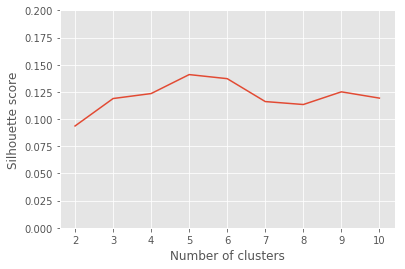

In [16]:
plt.figure(figsize=(6, 4))
plt.plot(clusters, scores)
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.ylim(ymin=0, ymax=.20)
plt.show()

The solution with 5 clusters produces the best silhouette score. The scores increase steadily from 2 to 5 but decrease after 5.

<h2>Understanding the Segments</h2>

At this point the cluster analysis suggests there are 5 customer segments, and the segments are assigned a number, but that number is arbitrary, and it doesn't tell me anything about what makes each segment unique. 
Below I use more data visualization to see the unique characteristics of each segment and understand why customers were grouped together. 

First I obtain the assigned segments for the 5-cluster solution, and link each customer with their assigned segment.

In [17]:
# # use 5-cluster solution
kmod = KMeans(n_clusters=5, random_state=10)
# obtain the cluster assignments
clusters = list(kmod.fit_predict(data))
# create a dataframe with the customer name and segment number
dfk5 = pd.DataFrame({'name': dfpv.index, 
                     'cluster': clusters})

Initially I'm curious whether the clusters are similar in size. Here I plot the percentage of all customers that fall into each segment. Each segment is identified by a number from 0-4, which is arbitrary at this point. 

In [18]:
# identify total number of customers
rows = dfk5.shape[0]

# count number of customers in each segment
dfk5pct = dfk5.groupby('cluster', as_index=False)['name'].count()
dfk5pct = dfk5pct.rename(columns={'name': 'percent'})

# divide customer sizes by total number of customers
dfk5pct['percent'] = (dfk5pct['percent'] / rows) * 100

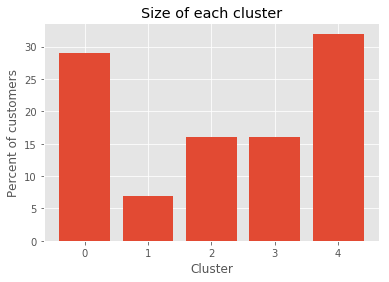

In [19]:
# create plot of segment size percentage over segment number
plt.bar(dfk5pct['cluster'], dfk5pct['percent'])
plt.xlabel("Cluster")
plt.ylabel("Percent of customers")
plt.ylim(ymin=0)
plt.title("Size of each cluster")
plt.show()

The smallest segment (#1) is only around 7% of the customers, two segments are equal at around 16% (#2 and #3), and segment #0 and #4 are the largest at around 30% each. 

At this point I want to know why the customers in each segment were grouped together, what makes them like each other, etc. I know that the algorithm grouped customers together because they had similar purchase patterns across all of the offers, but I haven't yet discovered whether those purchase patterns can be distilled in a clear way. 
To learn more about each segment's purchase patterns, I'll return to the original offers data that contained the details about the offers, like the varietal, the region, etc. By visualizing this data in relation to the customer segments, I hope to be able to identify some reasons why customers were grouped together. 

My sense about wine is the factor most people use to identify, talk about, and purchase wine is the varietal. I suspect each segment might have its own unique pattern of varietal purchasing. 

To investigate this idea further, I first transform the customers-orders data to compute the number of each varietal purchased by each customer, and merge this with the assigned cluster data. 

In [20]:
# group offer/order data by customer and varietal and count orders
df_temp = df.groupby(['name', 'varietal'], as_index=False)['n'].count()

# pivot data to get number of varietal orders for each customer
df_varcnt = pd.pivot_table(df_temp, index=['name'], values=['n'], 
               columns=['varietal'], aggfunc=np.sum, fill_value=0)

# remove indexes created by pivot
df_varcnt.columns = df_varcnt.columns.droplevel()
df_varcnt = df_varcnt.reset_index()

# merge the pivot table with the customer clusters
dfk5vars = pd.merge(dfk5, df_varcnt, how='inner', on='name') 
dfk5vars.head()

,cluster,name,Cabernet Sauvignon,Champagne,Chardonnay,Espumante,Malbec,Merlot,Pinot Grigio,Pinot Noir,Prosecco
0,0,Adams,0,0,0,1,1,0,1,0,0
1,4,Allen,0,1,1,0,0,0,0,0,0
2,2,Anderson,0,0,0,0,0,0,0,2,0
3,0,Bailey,0,0,0,0,1,0,0,0,1
4,3,Baker,0,2,0,0,0,0,0,0,2


This dataset now contains one row per customer containing the customer segment for each customer and also a count of the orders of each varietal type ordered by that customer. For example, the first customer (Adams) is in cluster 0 and ordered 1 each of Espumante, Malbec, and Pinot Grigio. 

To summarize the data across segments, I now compute the mean number of orders of each varietal type for each segment. 

In [21]:
# group data by cluster number, get mean number of orders for all varietals
dfk5_varmeans = dfk5vars.groupby('cluster').mean().transpose()
dfk5_varmeans.index.name = 'varietal'
dfk5_varmeans.reset_index(inplace=True)
del dfk5_varmeans.columns.name

Finally, I'll create a function to plot the mean number of varietal orders for each segment. 
By visualizing the average amount of each varietal that was ordered for each segment, I hope to see whether the segments are indeed differentiated by distinct patterns of varietal purchasing. 

In [22]:
def plot_cluster_profile(cluster):
    d_clus = dfk5_varmeans.loc[:, ['varietal', cluster]]
    d_clus.columns = ['varietal', 'mean']
    x = dfk5_varmeans['varietal']
    y = dfk5_varmeans[cluster]
    plt.figure(figsize=(14, 4))
    plt.bar(x, y)
    plt.xlabel("Varietal")
    plt.ylabel("Average orders per customer")
    plt.ylim(ymin=0, ymax=3)
    plt.show()

<h3>Segment 0 - "Mixed, no Champagne"</h3>

As shown below, customers in segment 0 ordered no Pinot Noir, Chardonnay, or Champagne, and some of just about everything else. I refer to them as <strong>"Mixed, no Champagne"</strong>, because as you'll see below, they're the only segment that ordered zero Champagne.

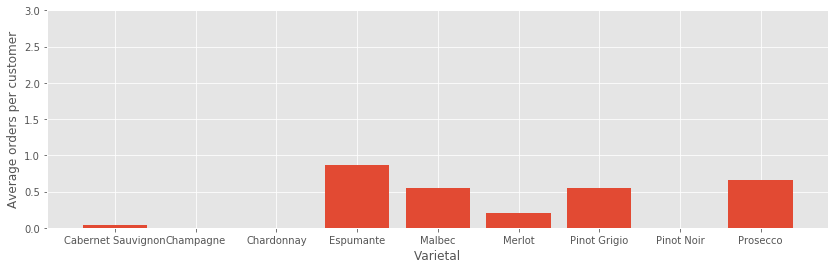

In [23]:
plot_cluster_profile(0)

<h3>Segment 1 - "Sparkling"</h3>

I call Segment 1 the <strong>"Sparkling"</strong> segment, because they ordered sparkling wines and nothing else.  

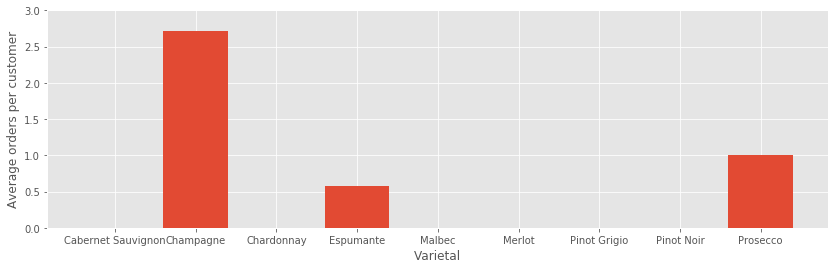

In [24]:
plot_cluster_profile(1)

<h3>Segment 2 - "Pinot Noir"</h3>

Segment 2 is the <strong>Pinot Noir</strong> segment. They ordered Pinot Noir and hardly anything else. 

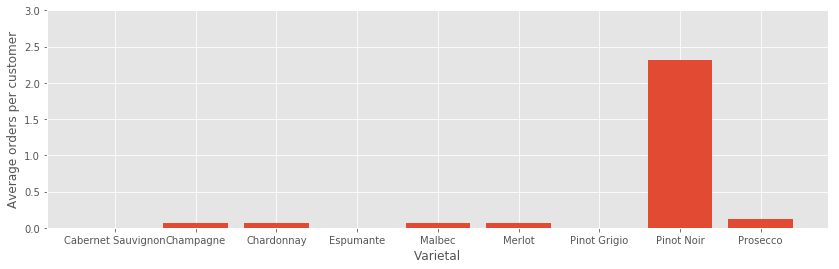

In [25]:
plot_cluster_profile(2)

<h3>Segment 3 - "Mixed, Heavy Champagne"</h3>

I call Segment 3 <strong>"Mixed, Heavy Champagne"</strong>. They ordered Champagne in relatively high amounts (average of 2 orders each), but dabbled in a few other varietals as well. 

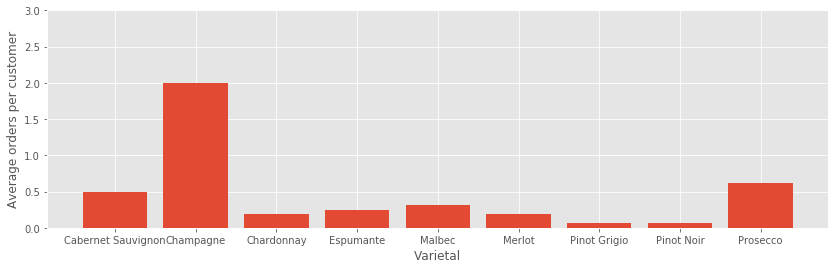

In [26]:
plot_cluster_profile(3)

<h3>Segment 4 - "Mixed"</h3>

The best label I could use for Segment 4 was <strong>"Mixed"</strong>. Like the "Mixed, Heavy Champagne" segment, this segment ordered more Champagne than other varietals, but their orders were more balanced, as they ordered nearly as much Cabernet Sauvignon as Champagne. 

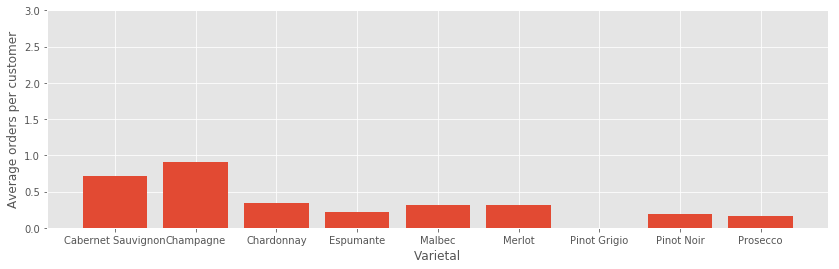

In [27]:
plot_cluster_profile(4)

<h2>Using the Segments</h2>
Now that the segments are defined, how might we use the segments to inform future marketing efforts or make other decisions?

I already learned that some segments were much larger than others, but before the segments had descriptive labels 
I reproduce the segment percentages below, this time with the segment labels.

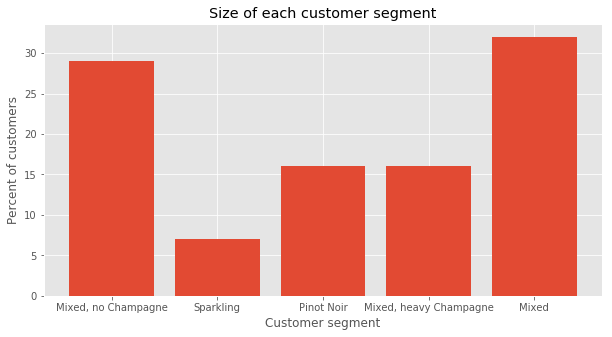

In [28]:
# define a segment dictionary to use as labels
clabs = {0: 'Mixed, no Champagne', 1: 'Sparkling', 2: 'Pinot Noir', 3: 'Mixed, heavy Champagne', 4: 'Mixed'}

x = dfk5pct['cluster'].map(clabs)
y = dfk5pct['percent']
plt.figure(figsize=(10, 5))
plt.bar(x, y)
plt.xlabel("Customer segment")
plt.ylabel("Percent of customers")
#plt.ylim(ymin=0, ymax=3)
plt.title("Size of each customer segment")
plt.show()

Knowing the size of each segment seems important, but perhaps more important is the volume of orders generated by each segment. Below I plot the percentage of all orders generated by each segment. 

In [29]:
# create a 'total' column counting the total number of orders for each customer
dfk5vars['total'] = dfk5vars.iloc[:, 2:10].sum(axis=1)
# group by cluster and sum cluster orders to compute percentage of all orders 
dfk5varpct = dfk5vars.groupby('cluster')['total'].sum() / dfk5vars['total'].sum() * 100
dfk5varpct = pd.DataFrame(dfk5varpct).reset_index()
dfk5varpct.rename(columns={'total': 'percent'}, inplace=True)

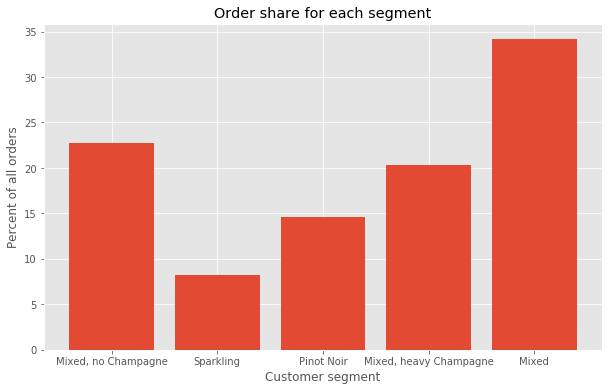

In [30]:
x = dfk5varpct['cluster'].map(clabs)
y = dfk5varpct['percent']
plt.figure(figsize=(10, 6))
plt.bar(x, y)
plt.xlabel("Customer segment")
plt.ylabel("Percent of all orders")
#plt.ylim(ymin=0, ymax=3)
plt.title("Order share for each segment")
plt.show()

I note that although the "Mixed" and "Mixed, no Champagne" segments are similar in size, the "Mixed" segment accounts for a much larger amount of orders. This makes sense: Champagne was the single varietal with the most offers, so the "Mixed" segment had more opportunities to purchase wines that they seem to prefer.  

On average, customers purchased 3.2 offers, but I'm curious if some segments tended to purchase more offers than others. 

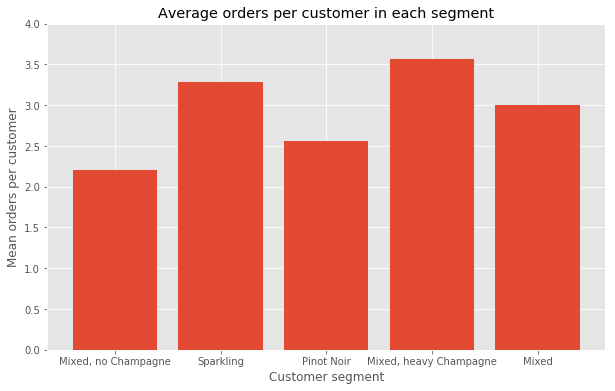

In [31]:
# group by cluster and sum cluster orders to compute percentage of all orders 
dfk5_cmeans = dfk5vars.groupby('cluster')['total'].mean()
x = clabs.values()
y = dfk5_cmeans.values
plt.figure(figsize=(10, 6))
plt.bar(x, y)
plt.xlabel("Customer segment")
plt.ylabel("Mean orders per customer")
plt.ylim(ymin=0, ymax=4)
plt.title("Average orders per customer in each segment")
plt.show()

On average, customers in each segment buy from from 2 to 3.5 offers. Interestingly, although the "Sparkling" and "Mixed, heavy Champagne" segments were 2 of the smaller segments, these segments have the most yield per customer. Again, this is probably a factor of Champagne having the most offers, and both of these segments seem to prefer Champagne. 

With these plots I've gain a few additional insights about the segments and orders:
- The "Mixed" and "Mixed, no Champagne" segments are similar in size, but the "Mixed" segment accounts for far more orders (34% versus 23%). 
- Although the "Mixed, Heavy Champagne" segment is about half the size as the "Mixed, no Champagne" segment, they account for a similar percentage of the orders. 
- On a per-customer basis, the segments with the most yield are the "Mixed, Heavy Champagne" and "Sparkling" segments. 

Overall, the main takeaway is that the Champagne-preferring customer segments account for relatively greater proportions of the orders than the no-Champagne segments. 

<h2> Summary and Recommendations</h2>



The customers fall into 5 segments that can be characterized reasonably well by the varietals they ordered. In order of size, the segments are:
<ul>
  <li>Mixed (32%) - A mix of all varietals, most often Champagne and Cabernet Sauvignon</li>
  <li>Mixed, no Champagne (29%) - A mix of a few varietals, with zero or very few orders of Champagne, Chardonnay, Pinot Noir, or Cab </li>
  <li>Mixed, Heavy Champagne (16%) - A mix of all varietals with a heavy preference for Champagne</li>
  <li>Pinot Noir (16%) - Pinot Noir and very rarely anything else</li> 
  <li>Sparkling (7%) - Only varietals that come in sparkling form</li>
</ul>

The champagne-ordering segments return the most orders per customer, led by the Mixed, Heavy Champagne segment (3.5 orders). 
<br>The non-Champagne segments return the fewest orders per customer. The Mixed, no Champagne segment had the lowest order rate (2.2 orders/customer), and is also the second-largest segment.

I recommend that the client personalize future offers to fit each segment's purchasing tendencies:
<ul>
  <li>Sparkling wine segment - Only sparkling wines</li>
  <li>Pinot Noir segment - Only Pinot Noir</li>
  <li>Mixed, no Champagne segment - A mix of varietals not including Champagne, Chardonnay, or Pinot Noir</li>
  <li>Mixed and Mixed, Heavy Champagne segments - A mix of varietals with an emphasis on Champagne</li> 
</ul>

I also recommend that the company focus customer acquisition efforts on new customers that buy champagne, since segments with these customers tend to produce the greatest return per customer. 